In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sc_stats
import json
import random
import seaborn as sns

import spacy

# Text analysis
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SpanishStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('tokenizers/punkt/spanish.pickle')
nltk.download('stopwords')

import unicodedata

from wordcloud import WordCloud, STOPWORDS

import analysis_utils as aute

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jose\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading tokenizers/punkt/spanish.pickle: Package
[nltk_data]     'tokenizers/punkt/spanish.pickle' not found in index
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
rdm_th = 0
corr_th = 0.85

nlp_spanish = spacy.load("es_core_news_sm")

random.seed(rdm_th)

In [3]:
with open('../LableniBotConfig/avoid_words.json', encoding='utf-8') as fh:
    avoid_words_list = json.load(fh)

tokenize_spanish = nltk.data.load('tokenizers/punkt/spanish.pickle')
spanish_stemmer = SpanishStemmer()
spanish_stopwords_th = stopwords.words('spanish')

In [4]:
def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

Only conversations with more than 5 sentences are taken in account.

In [5]:
path_to_conversations = "../Conversations/"

all_df_list = []
for conv in os.listdir(path_to_conversations):
    excel_name = [file for file in os.listdir(path_to_conversations + conv) if ".xlsx" in file][0]
    df_x = pd.read_excel(path_to_conversations + conv + "/" + excel_name)
    if df_x.shape[0] > 5:
        all_df_list.append(df_x)
            
print("Number of conversations:", len(all_df_list))

Number of conversations: 20


In [6]:
def clean_word(word):
    special_characters = ["?", "¿", "!", "¡", ".", ","]
    w_new = word.lower()
    for s_c in special_characters:
        w_new = w_new.replace(s_c, "")
        
    return w_new

def avoid_words_func(text):
    return " ".join([w for w in text.split() if clean_word(w) not in avoid_words_list])

def clean_text(text, subject_name, 
               tokenize_spanish=tokenize_spanish, 
               spanish_stopwords_th=spanish_stopwords_th, 
               spanish_stemmer=spanish_stemmer, 
               use_stemmer=True):
    
    text = text.lower()
    text = text.replace('?', "").replace('¿', "").replace('!', "").replace('¡', "")
    if subject_name:
        text = text.replace(subject_name, "")
    text = strip_accents(text)
    
    text_token_list = []
    if use_stemmer:
        for word in text.split():
            token_text = tokenize_spanish.tokenize(word)
            if len(token_text) > 0 and word not in spanish_stopwords_th:
                text_token_list.append(spanish_stemmer.stem(token_text[0]))
    else:
        text_token_list.append(text)
            
    text = " ".join(text_token_list)
    
    return text

In [30]:
save_res_list = []
for i_df_x, df_x in enumerate(all_df_list):
    
    subject_name = df_x["SubjectId"].iloc[0]
    
    # ###############
    # ### General ###
    # ###############
    num_conv = df_x.shape[0] // 2
    
    text = ". ".join(df_x["SpanishMessage"].values)
    whole_text = clean_text(text, subject_name)
    
    num_words = len(whole_text.split(" "))
    conv_time_s = df_x["UnixTimestampInit"].values[-1] - df_x["UnixTimestampEnd"].values[0]
    # freq_conv_s = np.mean(df_x["unixtimestamp"].values[1:] - df_x["unixtimestamp"].values[:-1])
    
    # The first raw is removed because the first answer is instantaneous
    time_answer_list, time_bot_answer_list, time_pers_answer_list = [], [], []
    for i in range(1, df_x.shape[0]-1):
        if df_x["Source"].iloc[i] == "Person":
            delta_t = df_x["UnixTimestampInit"].iloc[i+1] - df_x["UnixTimestampEnd"].iloc[i]
            time_bot_answer_list.append(delta_t)
        else:
            delta_t = df_x["UnixTimestampInit"].iloc[i+1] - df_x["UnixTimestampEnd"].iloc[i]
            time_pers_answer_list.append(delta_t)

        delta_t = df_x["UnixTimestampInit"].iloc[i+1] - df_x["UnixTimestampEnd"].iloc[i]
        time_answer_list.append(delta_t)
    
    # ###########
    # ### Bot ###
    # ###########
    df_bot = df_x[df_x["Source"] == "Bot"]
    
    text = ". ".join(df_bot["SpanishMessage"].values)
    bot_text = clean_text(text, subject_name)

    num_words_bot = len(bot_text.split(" "))
    
    # ##############
    # ### Person ###
    # ##############
    df_person = df_x[df_x["Source"] == "Person"]
    
    text = ". ".join(df_person["SpanishMessage"].values)
    person_text = clean_text(text, subject_name)
    
    num_words_person = len(person_text.split(" "))
    
    save_res_list.append({
        # General
        "SubjectId": df_x["SubjectId"].iloc[0],
        "FirstDate": df_x["UnixTimestampInit"].iloc[0],
        "LastDate": df_x["UnixTimestampEnd"].iloc[-1],
        "ConvTime_s": conv_time_s,
        # "FreqTime_s": freq_conv_s,
        "NumConv": num_conv,
        "NumSamples": df_x.shape[0],
        "AllText": avoid_words_func(whole_text),
        "AllNumUniqWords": len(set([w for w in whole_text.split() if w.isalpha()])),
        "AllOriginalText": avoid_words_func( ". ".join(df_x["SpanishMessage"].values) ),
        "AllNumWords": num_words,
        "AllTimeAns": np.mean(time_answer_list),
        # ### Bot ###
        "BotText": avoid_words_func(bot_text),
        "BotNumUniqWords": len(set([w for w in bot_text.split() if w.isalpha()])),
        "BotOriginalText": avoid_words_func( ". ".join(df_bot["SpanishMessage"].values) ),
        "BotNumWords": num_words_bot,
        "BotTimeAns": np.mean(time_bot_answer_list),
        # ### Person ###
        "PersonText": avoid_words_func(person_text),
        "PersonNumUniqWords": len(set([w for w in person_text.split() if w.isalpha()])),
        "PersonOriginalText": avoid_words_func( ". ".join(df_person["SpanishMessage"].values) ),
        "PersonNumWords": num_words_person,
        "PersonTimeAns": np.mean(time_pers_answer_list),
    })
    
df_save = pd.DataFrame(save_res_list)
df_save.head(5)

,SubjectId,FirstDate,LastDate,ConvTime_s,NumConv,NumSamples,AllText,AllNumUniqWords,AllOriginalText,AllNumWords,...,BotText,BotNumUniqWords,BotOriginalText,BotNumWords,BotTimeAns,PersonText,PersonNumUniqWords,PersonOriginalText,PersonNumWords,PersonTimeAns
0,Jose,1.659543e+09,1.659543e+09,42.649972,4,8,llamas. llamas. hol mari tal encuentras. hol m...,7,Como te llamas?. Como te llamas?. hola cómo es...,23,...,llamas. hol mari tal encuentras. alegr cuent h...,7,Como te llamas?. hola cómo estás qué tal te en...,11,0.013684,llamas. hol mari tal encuentras. alegr cuent h...,7,Como te llamas?. hola cómo estás qué tal te en...,11,0.625077
1,Jose,1.659543e+09,1.659544e+09,88.833958,4,8,llamas. llamas. hol mari cuentas. hol mari cue...,2,Como te llamas?. Como te llamas?. hola cómo es...,11,...,llamas. hol mari cuentas. vale.,2,Como te llamas?. hola cómo estás qué me cuenta...,5,0.025357,llamas. hol mari cuentas. vale.,2,Como te llamas?. hola cómo estás qué me cuenta...,5,19.783991
2,Jose,1.659544e+09,1.659544e+09,215.223754,3,6,llamas. llamas. hol mari verd pon dificil habl...,8,Como te llamas?. Como te llamas?. hola la verd...,21,...,llamas. hol mari verd pon dificil habl contig ...,8,Como te llamas?. hola la verdad que me estás p...,10,0.025964,llamas. hol mari verd pon dificil habl contig ...,8,Como te llamas?. hola la verdad que me estás p...,10,95.537006
3,Jose,1.659544e+09,1.659544e+09,157.749321,10,20,llamas. llamas. hol mari tal encuentras. hol m...,28,Como te llamas?. Como te llamas?. hola cómo es...,94,...,llamas. hol mari tal encuentras. pues bien ver...,28,Como te llamas?. hola cómo estás qué tal te en...,47,0.029769,llamas. hol mari tal encuentras. pues bien ver...,28,Como te llamas?. hola cómo estás qué tal te en...,47,4.568812
4,jOSE,1.659635e+09,1.659635e+09,29.656510,3,6,llam . llam hol mari tal encuentras. bien. muc...,10,Como te llamas ?. Me llamo hola cómo estás qué...,17,...,llam bien. much gracias..,2,Me llamo Estoy muy bien. Muchas gracias..,5,0.059541,llam . hol mari tal encuentras. alegr tambi bi...,9,Como te llamas ?. hola cómo estás qué tal te e...,11,3.292503


In [31]:
# Clean DF

df_save = df_save[df_save["PersonTimeAns"] <= 10]
df_save = df_save.reset_index(drop=True)

In [32]:
print("Shape", df_save.shape)
print("Columns", df_save.columns)

Shape (18, 21)
Columns Index(['SubjectId', 'FirstDate', 'LastDate', 'ConvTime_s', 'NumConv',
       'NumSamples', 'AllText', 'AllNumUniqWords', 'AllOriginalText',
       'AllNumWords', 'AllTimeAns', 'BotText', 'BotNumUniqWords',
       'BotOriginalText', 'BotNumWords', 'BotTimeAns', 'PersonText',
       'PersonNumUniqWords', 'PersonOriginalText', 'PersonNumWords',
       'PersonTimeAns'],
      dtype='object')


## EDA

In [10]:
aute.stat_print(df_save["ConvTime_s"]/60, "Conversation time (min)", 2)
aute.stat_print(df_save["NumSamples"], "Number Sentences ", 2)

Mean Conversation time (min) = 1.59 +/- 0.97 ; Median = 1.51 ; Min. =  0.49 ; Max. =  3.89
Mean Number Sentences  = 12.28 +/- 6.03 ; Median = 10.5 ; Min. =  6 ; Max. =  26


### Some plots

The following plots study the correlation of the number of words against the number of sentences and the time of the conversation. 

Correlation value 0.9205453166852146
P-value ***
Coefficients: 
 [13.15052398] 
Intercept: 
 -12.561448078755163
R-square: 0.85


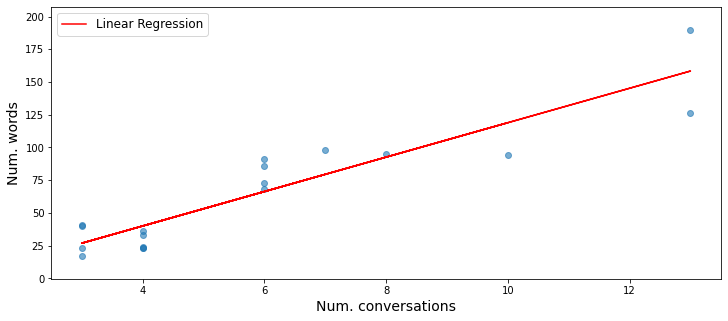

Correlation value 0.8711122483470994
P-value ***
Coefficients: 
 [0.66464212] 
Intercept: 
 2.1633518898362567
R-square: 0.76


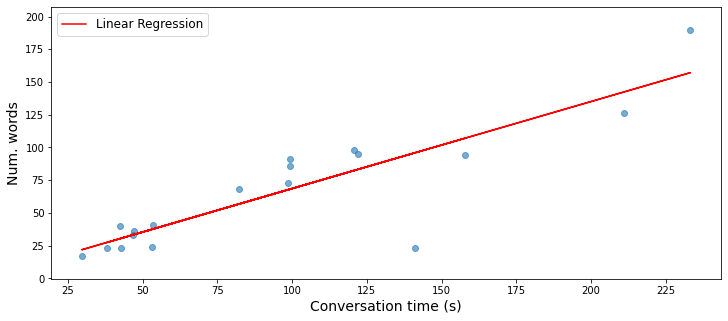

In [11]:
aute.make_scatter_plot(df=df_save, 
                       x_feat="NumConv", x_name="Num. conversations", 
                       y_feat="AllNumWords", y_name="Num. words", 
                       lr_mode=True)

aute.make_scatter_plot(df=df_save, 
                       x_feat="ConvTime_s", x_name="Conversation time (s)", 
                       y_feat="AllNumWords", y_name="Num. words", 
                       lr_mode=True)

Mean All number of words = 65.6111 +/- 44.5361 ; Median = 54.5 ; Min. =  17 ; Max. =  190
Mean Person number of words = 27.7222 +/- 22.4717 ; Median = 24.5 ; Min. =  2 ; Max. =  87
Mean Bot number of words = 37.6111 +/- 23.6623 ; Median = 34.0 ; Min. =  5 ; Max. =  103
P-value 0.2200314728354425 string p value -


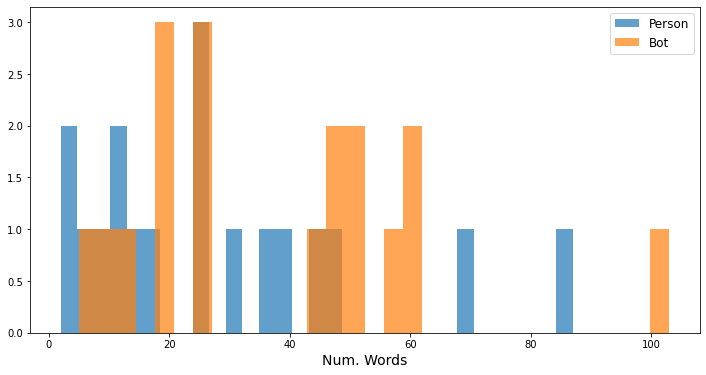

Mean Mean answer time (s) = 2.9 +/- 1.04 ; Median = 2.79 ; Min. =  0.32 ; Max. =  4.31
Mean Mean person answer time (s) = 6.18 +/- 2.16 ; Median = 6.33 ; Min. =  0.63 ; Max. =  9.25
Mean Mean bot answer time (s) = 0.02 +/- 0.01 ; Median = 0.01 ; Min. =  0.01 ; Max. =  0.06
P-value 1.5799971829399528e-13 string p value ***


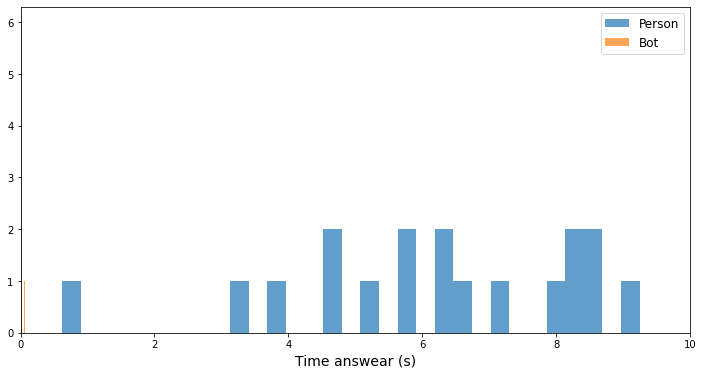

Mean All number of words = 26.6667 +/- 18.918 ; Median = 24.0 ; Min. =  5 ; Max. =  73
Mean Person unique words = 15.2222 +/- 11.9748 ; Median = 13.0 ; Min. =  0 ; Max. =  42
Mean Bot unique words = 17.7222 +/- 12.9392 ; Median = 15.0 ; Min. =  2 ; Max. =  50
P-value 0.5626290715756914 string p value -


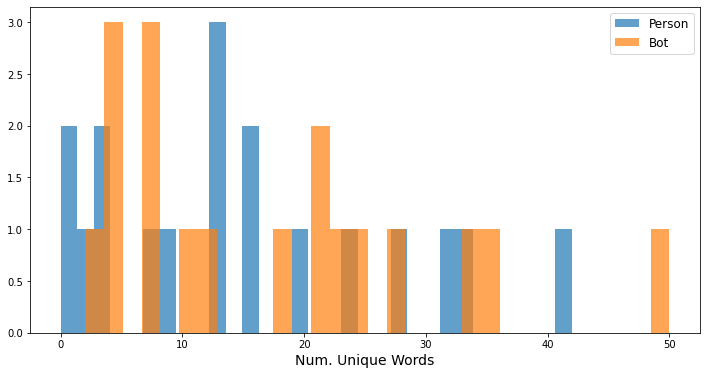

In [12]:
# #######################
# ### Number of words ###
# #######################

aute.stat_print(df_save["AllNumWords"].values, "All number of words")
aute.stat_print(df_save["PersonNumWords"].values, "Person number of words")
aute.stat_print(df_save["BotNumWords"].values, "Bot number of words")
_, p = sc_stats.f_oneway(df_save["PersonNumWords"].values, df_save["BotNumWords"].values)
print("P-value", p, "string p value", aute.get_p_string(p))

plt.figure(figsize=(12, 6))

plt.hist(df_save["PersonNumWords"].values, bins=31, alpha=0.7, label="Person")
plt.hist(df_save["BotNumWords"].values, bins=31, alpha=0.7, label="Bot")
plt.xlabel("Num. Words", fontsize=14)
plt.legend(fontsize=12)

plt.show()

# ###################
# ### Time answer ###
# ###################

aute.stat_print(df_save["AllTimeAns"].values, "Mean answer time (s)", 2)
aute.stat_print(df_save["PersonTimeAns"].values, "Mean person answer time (s)", 2)
aute.stat_print(df_save["BotTimeAns"].values, "Mean bot answer time (s)", 2)
_, p = sc_stats.f_oneway(df_save["PersonTimeAns"].values, df_save["BotTimeAns"].values)
print("P-value", p, "string p value", aute.get_p_string(p))

plt.figure(figsize=(12, 6))

plt.hist(df_save["PersonTimeAns"].values, bins=31, alpha=0.7, label="Person")
plt.hist(df_save["BotTimeAns"].values, bins=31, alpha=0.7, label="Bot")
plt.xlabel("Time answear (s)", fontsize=14)
plt.legend(fontsize=12)

plt.xlim(0, 10)

plt.show()

# ####################
# ### Unique words ###
# ####################

aute.stat_print(df_save["AllNumUniqWords"].values, "All number of words")
aute.stat_print(df_save["PersonNumUniqWords"].values, "Person unique words")
aute.stat_print(df_save["BotNumUniqWords"].values, "Bot unique words")
_, p = sc_stats.f_oneway(df_save["PersonNumUniqWords"].values, df_save["BotNumUniqWords"].values)
print("P-value", p, "string p value", aute.get_p_string(p))

plt.figure(figsize=(12, 6))

plt.hist(df_save["PersonNumUniqWords"].values, bins=31, alpha=0.7, label="Person")
plt.hist(df_save["BotNumUniqWords"].values, bins=31, alpha=0.7, label="Bot")
plt.xlabel("Num. Unique Words", fontsize=14)
plt.legend(fontsize=12)

plt.show()

### Crude Text 

#### Token size analysis

In [13]:
def obtain_word_analysis(data, target):
    result_list = []
    for text in data[target].tolist():
        original_text_clean = clean_text(text, subject_name=None, use_stemmer=False)
        sentence_list = []
        for sentence in original_text_clean.split(". "):
            if len(sentence) > 1:
                sentence_list.append(sentence)

        len_list = [len(sent.split()) for sent in sentence_list]
        result_list.append({
            "mean": np.mean(len_list),
            "median": np.median(len_list),
            "std": np.std(len_list),
            "num_words_in_sentence": len_list
        })

    return pd.DataFrame(result_list)

Mean Number of words for BOT by sentence = 7.5091 +/- 4.1961 ; Median = 7.0 ; Min. =  1 ; Max. =  20
Mean Number of words for Person by sentence = 9.3204 +/- 5.8992 ; Median = 8.0 ; Min. =  1 ; Max. =  31
P-value 0.003797875232807197 string p value **


C:\Users\Jose\Desktop\LabLENI\git\LableniBot\venv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Jose\Desktop\LabLENI\git\LableniBot\venv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jose\Desktop\LabLENI\git\LableniBot\venv\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\Users\Jose\Desktop\LabLENI\git\LableniBot\venv\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
C:\Users\Jose\Desktop\LabLENI\git\LableniBot\venv\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


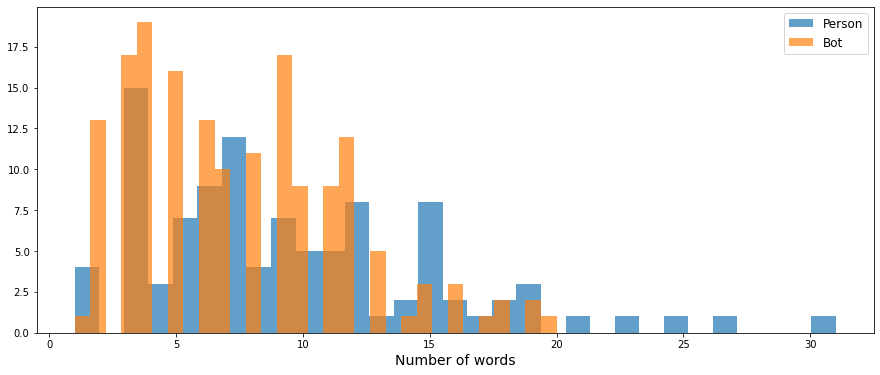

In [14]:
df_bot_result = obtain_word_analysis(df_save, "BotOriginalText")

bot_word_number = []
for my_list in df_bot_result["num_words_in_sentence"].tolist():
    bot_word_number += my_list
    
aute.stat_print(bot_word_number, "Number of words for BOT by sentence")

df_person_result = obtain_word_analysis(df_save, "PersonOriginalText")

person_word_number = []
for my_list in df_person_result["num_words_in_sentence"].tolist():
    person_word_number += my_list

aute.stat_print(person_word_number, "Number of words for Person by sentence")

_, p = sc_stats.f_oneway(person_word_number, bot_word_number)
print("P-value", p, "string p value", aute.get_p_string(p))

plt.figure(figsize=(15, 6))

plt.hist(person_word_number, bins=31, alpha=0.7, label="Person")
plt.hist(bot_word_number, bins=31, alpha=0.7, label="Bot")
plt.xlabel("Number of words", fontsize=14)
plt.legend(fontsize=12)

plt.show()

Mean Number of words for ALL by sentence = 8.236 +/- 5.0184 ; Median = 7.0 ; Min. =  1 ; Max. =  31


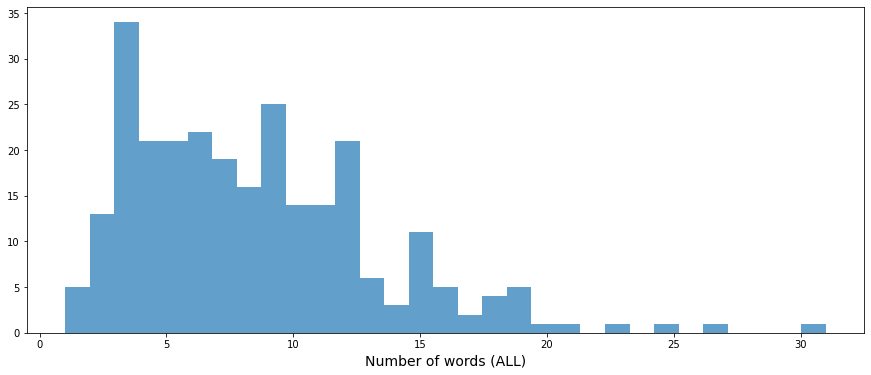

In [15]:
df_all_result = obtain_word_analysis(df_save, "AllOriginalText")

all_word_number = []
for my_list in df_all_result["num_words_in_sentence"].tolist():
    all_word_number += my_list

aute.stat_print(all_word_number, "Number of words for ALL by sentence")

plt.figure(figsize=(15, 6))

plt.hist(all_word_number, bins=31, alpha=0.7, label="All")
plt.xlabel("Number of words (ALL)", fontsize=14)

plt.show()

## WordCloud analysis

- Falta tokenizar las palabras, eliminar acentos y etc.

- Estaria bien establecer un protocolo para eliminar el nombre del sujeto.

- Estudiar el número y cuales son las stopwords localizadas en el Bot y en la persona. Ver si estas stopwords son las mismas para ambos o distintas, etc. Posiblemente el sujeto utilice más stopwords que el sujeto o quizá no. 

### Whole text

In [16]:
whole_text = " ".join(df_save["AllOriginalText"]).replace(".", " ").replace(",", " ").lower()

all_words_list = [word for word in whole_text.split() if word not in spanish_stopwords_th]
uniq_words_list = list(set(all_words_list))
freq_words_appear = [
    {"Word": word, "Times": np.sum(np.array(all_words_list)==word)} for word in uniq_words_list
]
df_freq_all_words = pd.DataFrame(freq_words_appear).sort_values("Times", ascending=False).reset_index(drop=True)
df_freq_all_words.head(15)

,Word,Times
0,bien,35
1,?,28
2,hola,26
3,pues,24
4,verdad,22
5,gracias,20
6,llamas,17
7,si,16
8,hablar,16
9,tal,16


In [17]:
print("Number of different words", df_freq_all_words.shape[0])
print("Mean frequency", np.round(np.mean(df_freq_all_words["Times"]), 5), 
      "+/-", np.round(np.std(df_freq_all_words["Times"]), 5), 
      "Max", np.max(df_freq_all_words["Times"]), 
      "Min", np.min(df_freq_all_words["Times"]) )

Number of different words 426
Mean frequency 2.62676 +/- 3.82899 Max 35 Min 1


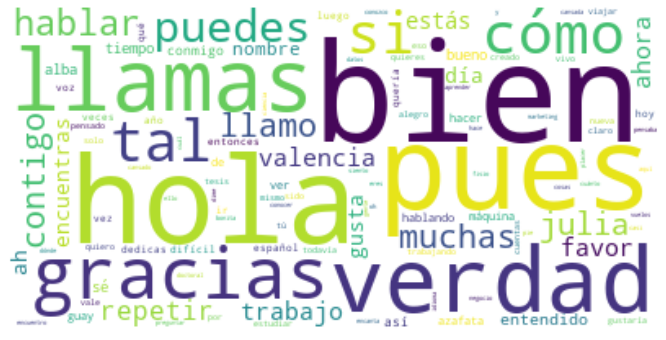

In [18]:
plt.figure(figsize=(15, 6))

all_wordcloud = WordCloud(collocations = False, background_color = 'white').generate(" ".join(all_words_list))

plt.imshow(all_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Bot analysis

In [19]:
whole_bot_text = " ".join(df_save["BotOriginalText"]).replace(".", " ").replace(",", " ").lower()

all_bot_words_list = [word for word in whole_bot_text.split() if word not in spanish_stopwords_th]
uniq_bot_words_list = list(set(all_bot_words_list))
freq_bot_words_appear = [
    {"Word": word, "Times": np.sum(np.array(all_bot_words_list)==word)} for word in uniq_bot_words_list
]
df_freq_bot_words = pd.DataFrame(freq_bot_words_appear).sort_values("Times", ascending=False).reset_index(drop=True)
df_freq_bot_words.head(15)

,Word,Times
0,bien,23
1,?,20
2,gracias,16
3,repetir,11
4,favor,11
5,puedes,11
6,hola,11
7,trabajo,9
8,entendido,9
9,llamas,9


In [20]:
print("Number of different words", df_freq_bot_words.shape[0])
print("Mean frequency", np.round(np.mean(df_freq_bot_words["Times"]), 5), 
      "+/-", np.round(np.std(df_freq_bot_words["Times"]), 5), 
      "Max", np.max(df_freq_bot_words["Times"]), 
      "Min", np.min(df_freq_bot_words["Times"]) )

Number of different words 322
Mean frequency 2.04037 +/- 2.48378 Max 23 Min 1


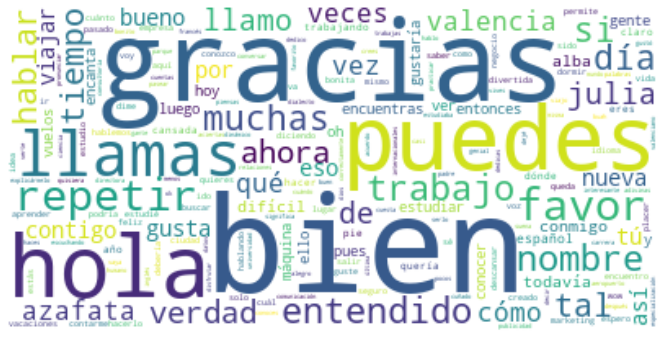

In [21]:
plt.figure(figsize=(15, 6))

all_wordcloud = WordCloud(collocations = False, background_color = 'white').generate(" ".join(all_bot_words_list))

plt.imshow(all_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Analysis against Questionare

In [22]:
random_target = [np.random.randint(1, 5+1) for _ in range(df_save.shape[0])]
random_binary_target = [np.random.randint(0, 1+1) for _ in range(df_save.shape[0])]

In [23]:
df_save["MultilabelTarget"] = random_target
df_save["BinaryTarget"] = random_binary_target

In [24]:
aute.stat_print(df_save["MultilabelTarget"], "Realism degree score", precision=2)
aute.stat_print(100 * df_save["BinaryTarget"], "Repetition score", precision=2)

Mean Realism degree score = 2.89 +/- 1.24 ; Median = 3.0 ; Min. =  1 ; Max. =  5
Mean Repetition score = 33.33 +/- 47.14 ; Median = 0.0 ; Min. =  0 ; Max. =  100


In [25]:
print("Columns", df_save.columns)
df_save.head(5)

Columns Index(['SubjectId', 'FirstDate', 'LastDate', 'ConvTime_s', 'NumConv',
       'NumSamples', 'AllText', 'AllNumUniqWords', 'AllOriginalText',
       'AllNumWords', 'AllTimeAns', 'BotText', 'BotNumUniqWords',
       'BotOriginalText', 'BotNumWords', 'BotTimeAns', 'PersonText',
       'PersonNumUniqWords', 'PersonOriginalText', 'PersonNumWords',
       'PersonTimeAns', 'MultilabelTarget', 'BinaryTarget'],
      dtype='object')


,SubjectId,FirstDate,LastDate,ConvTime_s,NumConv,NumSamples,AllText,AllNumUniqWords,AllOriginalText,AllNumWords,...,BotOriginalText,BotNumWords,BotTimeAns,PersonText,PersonNumUniqWords,PersonOriginalText,PersonNumWords,PersonTimeAns,MultilabelTarget,BinaryTarget
0,Jose,1.659543e+09,1.659543e+09,42.649972,4,8,llamas. llamas. hol mari tal encuentras. hol m...,7,Como te llamas?. Como te llamas?. hola cómo es...,23,...,Como te llamas?. hola cómo estás qué tal te en...,11,0.013684,llamas. hol mari tal encuentras. alegr cuent h...,7,Como te llamas?. hola cómo estás qué tal te en...,11,0.625077,5,0
1,Jose,1.659544e+09,1.659544e+09,157.749321,10,20,llamas. llamas. hol mari tal encuentras. hol m...,28,Como te llamas?. Como te llamas?. hola cómo es...,94,...,Como te llamas?. hola cómo estás qué tal te en...,47,0.029769,llamas. hol mari tal encuentras. pues bien ver...,28,Como te llamas?. hola cómo estás qué tal te en...,47,4.568812,3,0
2,jOSE,1.659635e+09,1.659635e+09,29.656510,3,6,llam . llam hol mari tal encuentras. bien. muc...,10,Como te llamas ?. Me llamo hola cómo estás qué...,17,...,Me llamo Estoy muy bien. Muchas gracias..,5,0.059541,llam . hol mari tal encuentras. alegr tambi bi...,9,Como te llamas ?. hola cómo estás qué tal te e...,11,3.292503,3,0
3,Jose,1.659636e+09,1.659636e+09,121.929743,8,16,llam . llam mari . . hol mari llam estas. bien...,48,Como te llamas ?. Me llamo . . hola yo me llam...,95,...,"Me llamo . . Estoy bien, gracias. Y tú, . Está...",50,0.027504,llam . hol mari llam estas. pues bien much gra...,32,Como te llamas ?. hola yo me llamo cómo estás....,45,6.619956,2,0
4,Jose,1.660070e+09,1.660070e+09,210.888672,13,26,"llam . llam mari . . hola, mari tal encuentras...",48,"Como te llamas ?. Me llamo . . Hola, cómo está...",126,...,"Me llamo . . Estoy bien, gracias. Y tú? . . So...",57,0.015881,"llam . hola, mari tal encuentras. pues bien, v...",33,"Como te llamas ?. Hola, cómo estás? Qué tal te...",69,5.317663,1,0


Correlation value -0.028004140740781693
P-value -
Coefficients: 
 [-3.1348064] 
Intercept: 
 2.948605259372132
R-square: 0.00


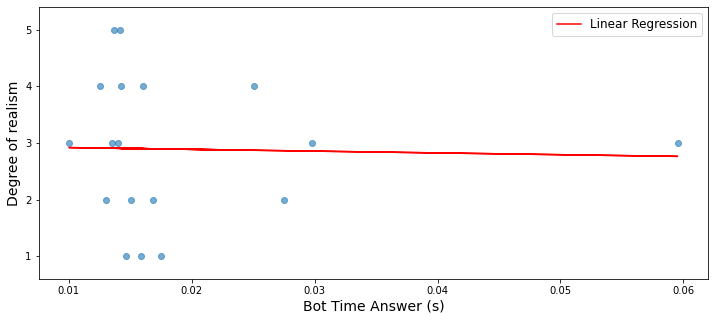

Correlation value -0.5747537398342561
P-value *
Coefficients: 
 [-0.11848704] 
Intercept: 
 4.343646408839779
R-square: 0.33


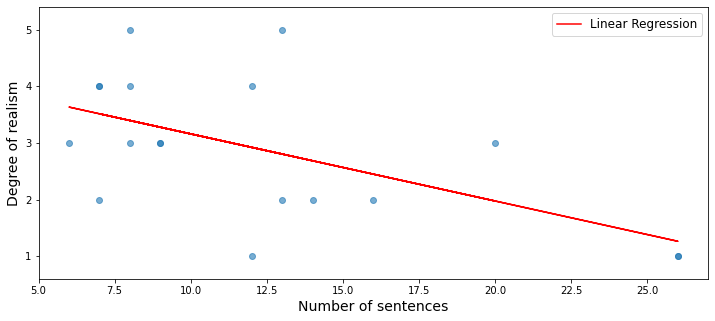

Correlation value -0.5791172192379062
P-value *
Coefficients: 
 [-0.05559959] 
Intercept: 
 3.8742372568900354
R-square: 0.34


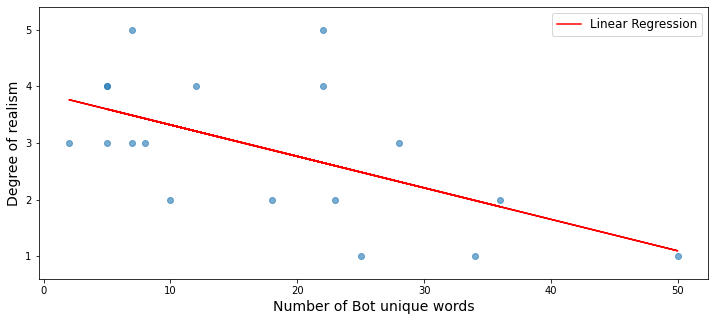

Correlation value -0.6062648126688888
P-value **
Coefficients: 
 [-0.03182863] 
Intercept: 
 4.085999040841414
R-square: 0.37


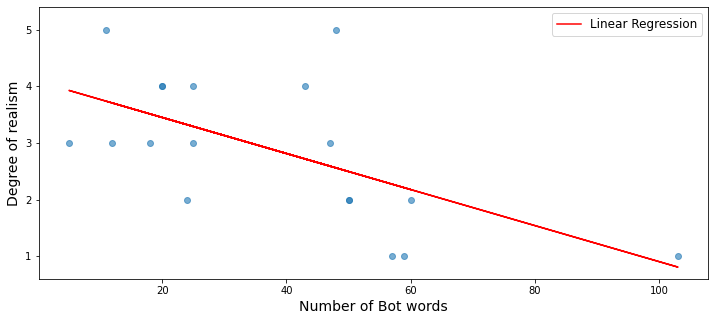

In [26]:
aute.make_scatter_plot(df=df_save, 
                       x_feat="BotTimeAns", x_name="Bot Time Answer (s)", 
                       y_feat="MultilabelTarget", y_name="Degree of realism", 
                       lr_mode=True)

aute.make_scatter_plot(df=df_save, 
                       x_feat="NumSamples", x_name="Number of sentences", 
                       y_feat="MultilabelTarget", y_name="Degree of realism", 
                       lr_mode=True)

aute.make_scatter_plot(df=df_save, 
                       x_feat="BotNumUniqWords", x_name="Number of Bot unique words", 
                       y_feat="MultilabelTarget", y_name="Degree of realism", 
                       lr_mode=True)

aute.make_scatter_plot(df=df_save, 
                       x_feat="BotNumWords", x_name="Number of Bot words", 
                       y_feat="MultilabelTarget", y_name="Degree of realism", 
                       lr_mode=True)

P-value 0.19761712117816224 with significance -


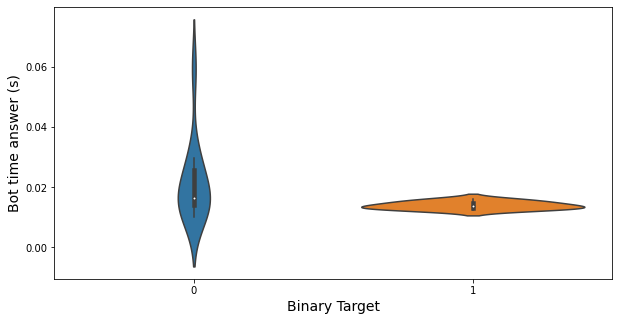

P-value 0.13631684276267902 with significance -


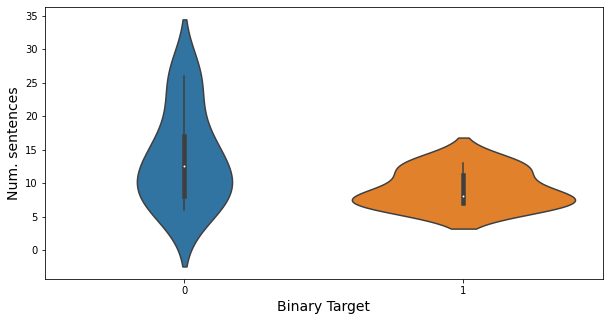

P-value 0.25099306545613365 with significance -


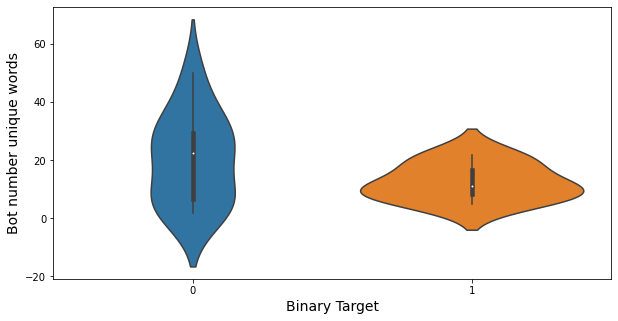

P-value 0.36405343835945814 with significance -


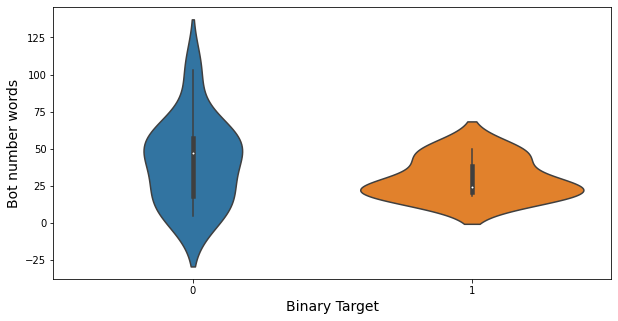

In [27]:
aute.make_binary_plot(data=df_save, 
                      x_feat="BinaryTarget", x_name="Binary Target", 
                      y_feat="BotTimeAns", y_name="Bot time answer (s)", 
                      violin_plot=True)

aute.make_binary_plot(data=df_save, 
                      x_feat="BinaryTarget", x_name="Binary Target", 
                      y_feat="NumSamples", y_name="Num. sentences", 
                      violin_plot=True)

aute.make_binary_plot(data=df_save, 
                      x_feat="BinaryTarget", x_name="Binary Target", 
                      y_feat="BotNumUniqWords", y_name="Bot number unique words", 
                      violin_plot=True)

aute.make_binary_plot(data=df_save, 
                      x_feat="BinaryTarget", x_name="Binary Target", 
                      y_feat="BotNumWords", y_name="Bot number words", 
                      violin_plot=True)

## Study sentence similarity

In [28]:
# ### Bot ###

all_bot_sentence_list = []
for sent in df_save["BotOriginalText"].tolist():
    all_bot_sentence_list += sent.split(". ")

save_vector_list = []
for sent in all_bot_sentence_list:
    doc_sent_nlp = nlp_spanish(sent)
    if doc_sent_nlp.vector.shape[0] > 0:
        save_vector_list.append( doc_sent_nlp.vector/doc_sent_nlp.vector_norm )
    
save_res_similarity_bot_list = []
for i, i_sent in enumerate(save_vector_list[:-1]):
    for j_sent in save_vector_list[(i+1):]:
        save_res_similarity_bot_list.append(
            aute.cosine_similarity(i_sent, j_sent)
        )
        
# ### Person ###
        
all_person_sentence_list = []
for sent in df_save["PersonOriginalText"].tolist():
    all_person_sentence_list += sent.split(". ")

save_vector_list = []
for sent in all_person_sentence_list:
    doc_sent_nlp = nlp_spanish(sent)
    if doc_sent_nlp.vector.shape[0] > 0:
        save_vector_list.append( doc_sent_nlp.vector/doc_sent_nlp.vector_norm )
    
save_res_similarity_person_list = []
for i, i_sent in enumerate(save_vector_list[:-1]):
    for j_sent in save_vector_list[(i+1):]:
        save_res_similarity_person_list.append(
            aute.cosine_similarity(i_sent, j_sent)
        )

Mean Bot sentence similarity = 0.2545 +/- 0.1912 ; Median = 0.2538 ; Min. =  -0.3369 ; Max. =  1.0
Mean Person sentence similarity = 0.2846 +/- 0.1939 ; Median = 0.2793 ; Min. =  -0.3144 ; Max. =  1.0


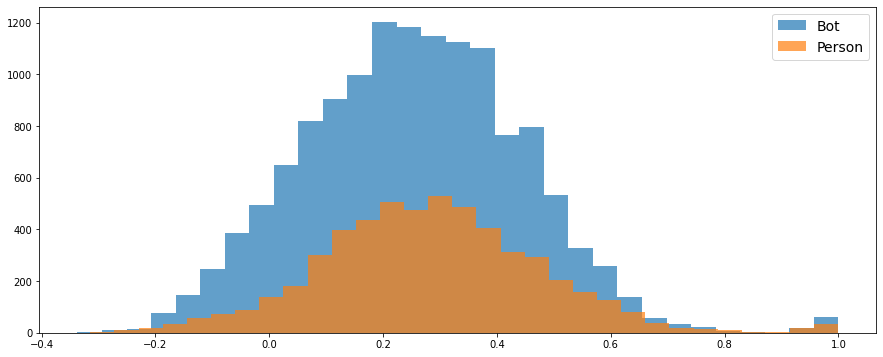

In [29]:
aute.stat_print(save_res_similarity_bot_list, "Bot sentence similarity")
aute.stat_print(save_res_similarity_person_list, "Person sentence similarity")

plt.figure(figsize=(15, 6))

plt.hist(save_res_similarity_bot_list, bins=31, alpha=0.7, label="Bot")
plt.hist(save_res_similarity_person_list, bins=31, alpha=0.7, label="Person")

plt.legend(fontsize=14)

plt.show()

### Classifier

- Hacer un clasificador que sepa o pueda descubrir por las métricas obtenidas de la conversación si es un Bot o una persona. Lo interesante sería que NO.